In [1]:
import numpy as np
import pandas as pd

estimates = pd.read_pickle("../output/estimates_sim_records_recall.pickle")
ground_truth = pd.read_csv("../output/ground_truth.tsv", sep="\t")

In [2]:
ground_truth.rename(columns={"Unnamed: 0":"rate"}, inplace=True)

In [3]:
ground_truth

,rate,precision,recall
0,5,0.900896,0.902363
1,10,0.805255,0.809002
2,20,0.634220,0.639422


In [4]:
estimates["mean_ests"] = estimates.apply(lambda x: np.mean(x.estimates, where=~np.isnan(x.estimates)), axis=1)
estimates["rate"] = estimates["rate"].astype(int)
estimates["gt_recall"] = estimates.apply(lambda x: ground_truth.set_index("rate").recall[x.rate], axis=1)
estimates["bias"] = estimates.apply(lambda x: x.mean_ests - x.gt_recall, axis=1)
estimates["rmse"] = estimates.apply(lambda x: np.sqrt(np.mean((np.array(x.estimates) - x.gt_recall)**2)), axis=1)

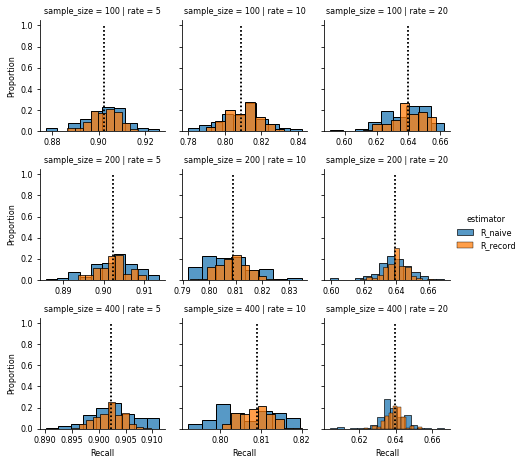

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=8) #controls default text size
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 

dat = estimates.query('estimator != "P_single_block"')
dat = (
    dat
    .estimates
    .apply(pd.Series)
    .merge(dat, right_index=True, left_index=True)
    .melt(id_vars=['sample_size', 'rate', 'estimator', 'estimates', 'gt_recall', 'mean_ests', 'bias', 'rmse'], value_name="estimate")
    .rename(columns={"estimate":"Recall"})
)

g = sns.FacetGrid(dat, hue="estimator", col="rate", row="sample_size", sharey=True, sharex=False, height=6.5/3)
g.map(sns.histplot, "Recall", kde=False, common_norm=True, stat="proportion", multiple="layer")
g.add_legend()

gt_recall = ground_truth.set_index("rate")["recall"]
for x in g.facet_data():
    ax = g.facet_axis(x[0][0], x[0][1])
    rate = x[1].rate.values[0]
    plt.vlines(x=gt_recall[rate], ymin=0, ymax=1, color="black", linestyles="dotted")

plt.savefig("../output/sim_records_recall.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [6]:
estimates

,sample_size,rate,estimator,estimates,mean_ests,gt_recall,bias,rmse
0,100,20,R_naive,"[0.6147824410020899, 0.6441710099013211, 0.640...",0.638655,0.639422,-0.000767,0.013193
1,100,20,R_record,"[0.6208427509167582, 0.6432272916899724, 0.639...",0.639913,0.639422,0.000490,0.009910
2,100,5,R_naive,"[0.9033698996295533, 0.9010327633839197, 0.906...",0.903019,0.902363,0.000656,0.008912
3,100,5,R_record,"[0.8993394564838174, 0.9006313642886373, 0.907...",0.902576,0.902363,0.000213,0.006003
4,100,10,R_naive,"[0.8073430086018998, 0.8124725717939824, 0.797...",0.809887,0.809002,0.000886,0.012263
5,100,10,R_record,"[0.8081938790388321, 0.8087170154251786, 0.800...",0.810081,0.809002,0.001080,0.008886
6,200,20,R_naive,"[0.6309610298832355, 0.6524520190810058, 0.651...",0.638432,0.639422,-0.000991,0.010919
7,200,20,R_record,"[0.6315858343148579, 0.646563612667403, 0.6444...",0.639566,0.639422,0.000144,0.007083
8,200,5,R_naive,"[0.908331062988984, 0.9077964957135877, 0.8993...",0.902435,0.902363,0.000072,0.005636
9,200,5,R_record,"[0.9021517751475341, 0.9062773741545419, 0.902...",0.902310,0.902363,-0.000053,0.003748


In [7]:
table = estimates[["rate", "sample_size", "mean_ests", "gt_recall", "bias", "rmse", "estimator"]]
table = table.sort_values(["rate", "sample_size", "estimator"])
table = table.pivot(index=["rate", "sample_size"], columns="estimator", values=["bias", "rmse"]).T

table.round(3).style.format(precision=3, escape="latex").to_latex(buf="../output/table_recall.tex", multirow_align="c", multicol_align="c", hrules=True)